# Part A: Stock Price Forecasting

# 0. Import required libraries

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import module for seasonal
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Import modules for acf and pcaf plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import itertools
import itertools

# Warnings 
import warnings
warnings.filterwarnings('ignore')

# Changing directory to the folder with the dataset
import os
os.chdir('C:\SP\Year 1 Sem 2\Artificial Intelligence and Machine Learning (AIML)\AIML CA2\Datasets')

# 1. Preprocessing the data

In [2]:
# Loading the dataset
df = pd.read_csv('CA2-Stock-Price-Data.csv', 
                index_col='Date',
                parse_dates=True)

df

,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
...,...,...,...
2023-09-22,174.789993,129.119995,33.250000
2023-09-25,176.080002,131.270004,33.450001
2023-09-26,171.960007,125.980003,33.509998


In [3]:
# Show the columns present in the dataset
list(df.columns)

['Apple', 'Amazon', 'DBS']

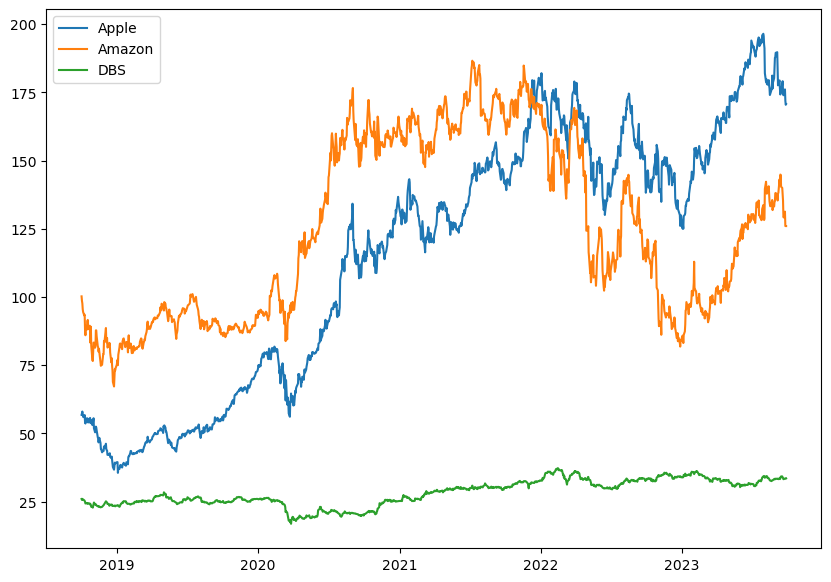

In [4]:
plt.figure(figsize=(10,7))

plt.plot(df.index, df[['Apple', 'Amazon', 'DBS']], label=['Apple', 'Amazon', 'DBS'])

plt.legend()
plt.show()

## Checking whether the dataset contain any duplicates  

In [5]:
# Check and removing duplicate rows
print("Before dropping duplicates")
print(df.shape)

df = df.drop_duplicates()

print("\nAfter dropping duplicates")
print(df.shape)

Before dropping duplicates
(1257, 3)

After dropping duplicates
(1257, 3)


## Check if the dataset contain any missing values

<Axes: ylabel='Date'>

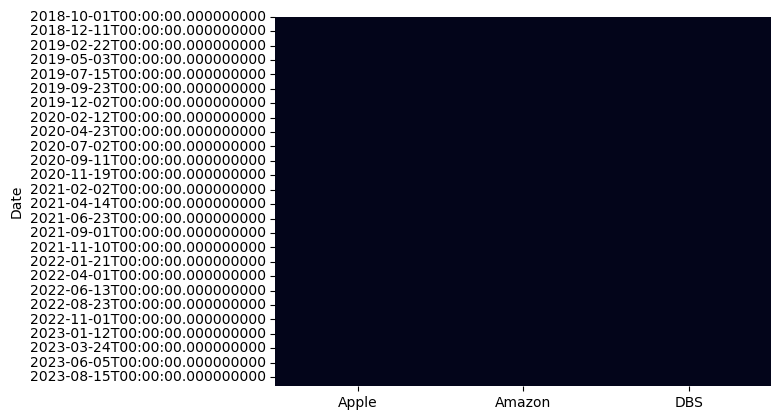

In [6]:
# Heatmap showing missing values (in white)
sns.heatmap(df.isnull(), cbar=False)

### Check whether the dataset contains missing dates 

In [7]:
# Create a complete date range
complete_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Resample the DataFrame to the complete date range
resampled_df = df.resample('D').asfreq()

# Count the number of missing dates
num_missing_dates = resampled_df[df.columns[0]].isna().sum()  # Replace df.columns[0] with the column you want to check

print("Number of missing dates:", num_missing_dates)

Number of missing dates: 567


There is 567 missing dates in the dataset, so I will be imputing the data in these dates using forward fill.

In [8]:
# Create a new DataFrame containing the entire range of the dates
datetime_df = pd.DataFrame(index=pd.date_range(start=df.index[0], end=df.index[(len(df)) - 1], freq='D'))

# Add the missing dates back into the original df
df = datetime_df.join(df, how='left')

# Check how many NaN values are in the df after imputing the missing dates
df.isna().value_counts()

Apple  Amazon  DBS  
False  False   False    1257
True   True    True      567
Name: count, dtype: int64

There is a total of 567 missing data

In [9]:
# Imputing missing data with forward fill
df = df.ffill()

# Double check the number of NaN values in df
df.isna().value_counts()

Apple  Amazon  DBS  
False  False   False    1824
Name: count, dtype: int64

In [10]:
df

,Apple,Amazon,DBS
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
...,...,...,...
2023-09-24,174.789993,129.119995,33.250000
2023-09-25,176.080002,131.270004,33.450001
2023-09-26,171.960007,125.980003,33.509998
2023-09-27,170.429993,125.980003,33.430000


## Testing for white noise

In [11]:
# Import required libraries for ADF Test
from statsmodels.tsa.stattools import adfuller

### ADF Test

In [12]:
company = ['Apple', 'Amazon', 'DBS']

for company in company:
    # ADF test for stationarity
    adf_result = adfuller(df[company])
    print(f'ADF Statistic ({company}): {adf_result[0]}')
    print(f'p-value ({company}): {adf_result[1]}\n')

ADF Statistic (Apple): -0.9838100771942361
p-value (Apple): 0.7591233096947595

ADF Statistic (Amazon): -1.575605610379156
p-value (Amazon): 0.4958349516623555

ADF Statistic (DBS): -1.2675427384561586
p-value (DBS): 0.6438876920102607



* H0 : The series is non-stationary
* H1 : The series is stationary

As all 3 p-values are larger than 0.05, I CANNOT reject the null hypothesis of non-stationarity. Thus, concluding that they are non-stationary.

I will need to transform them into stationary time series.

## Transforming to Stationary series 

### Amazon

In [13]:
## Amazon

# First Differencing
df['Amazon_diff'] = df['Amazon'].diff()

# Log + First Differencing
df['log_Amazon_diff'] = np.log(df['Amazon']).diff()

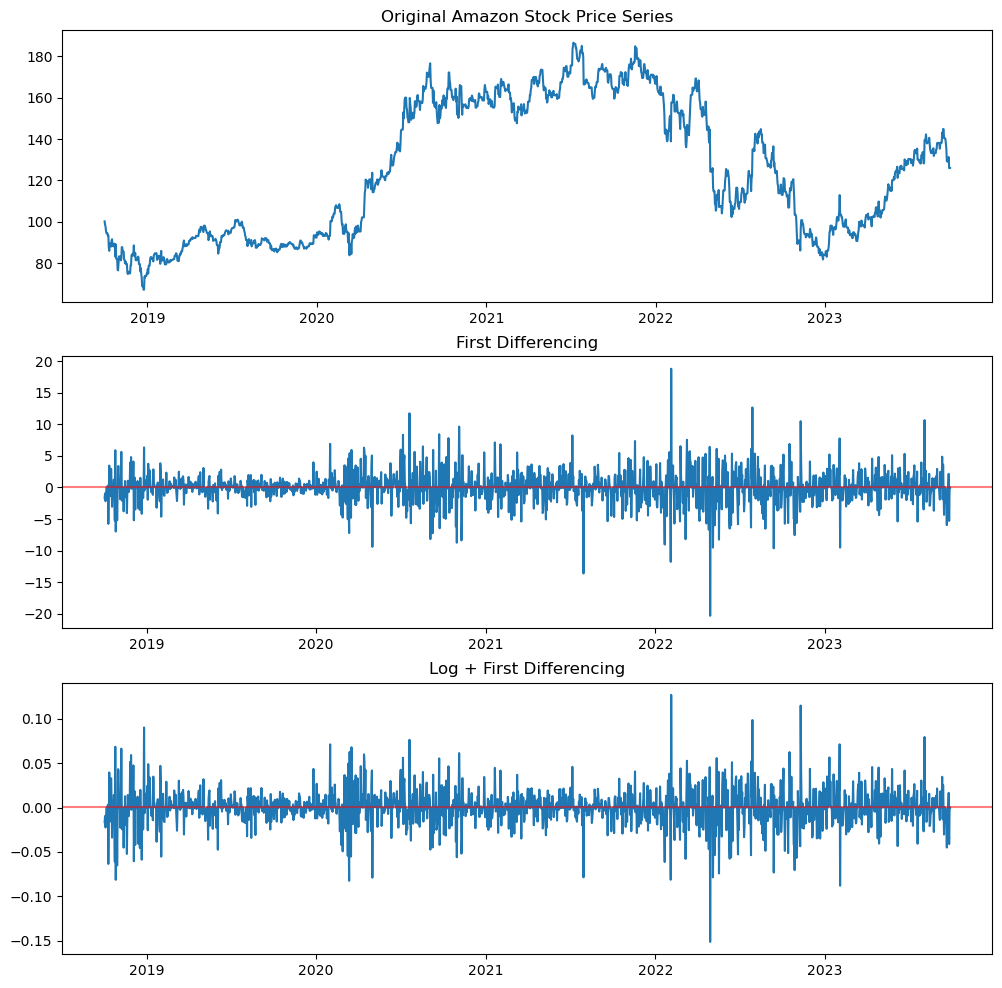

In [14]:
# Check if the series is stationary and transform the series if they are not
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(df['Amazon'])
ax[0].set_title('Original Amazon Stock Price Series')
    
ax[1].plot(df['Amazon_diff'])
ax[1].set_title('First Differencing')
ax[1].axhline(y=df['Amazon_diff'].mean(), color='r', alpha=0.5)

ax[2].plot(df['log_Amazon_diff'])
ax[2].set_title('Log + First Differencing')
ax[2].axhline(y=df['log_Amazon_diff'].mean(), color='r', alpha=0.5)

plt.show()

### Apple 

In [15]:
## Apple

# First Differencing
df['Apple_diff'] = df['Apple'].diff()

# Log + First Differencing
df['log_Apple_diff'] = np.log(df['Apple']).diff()

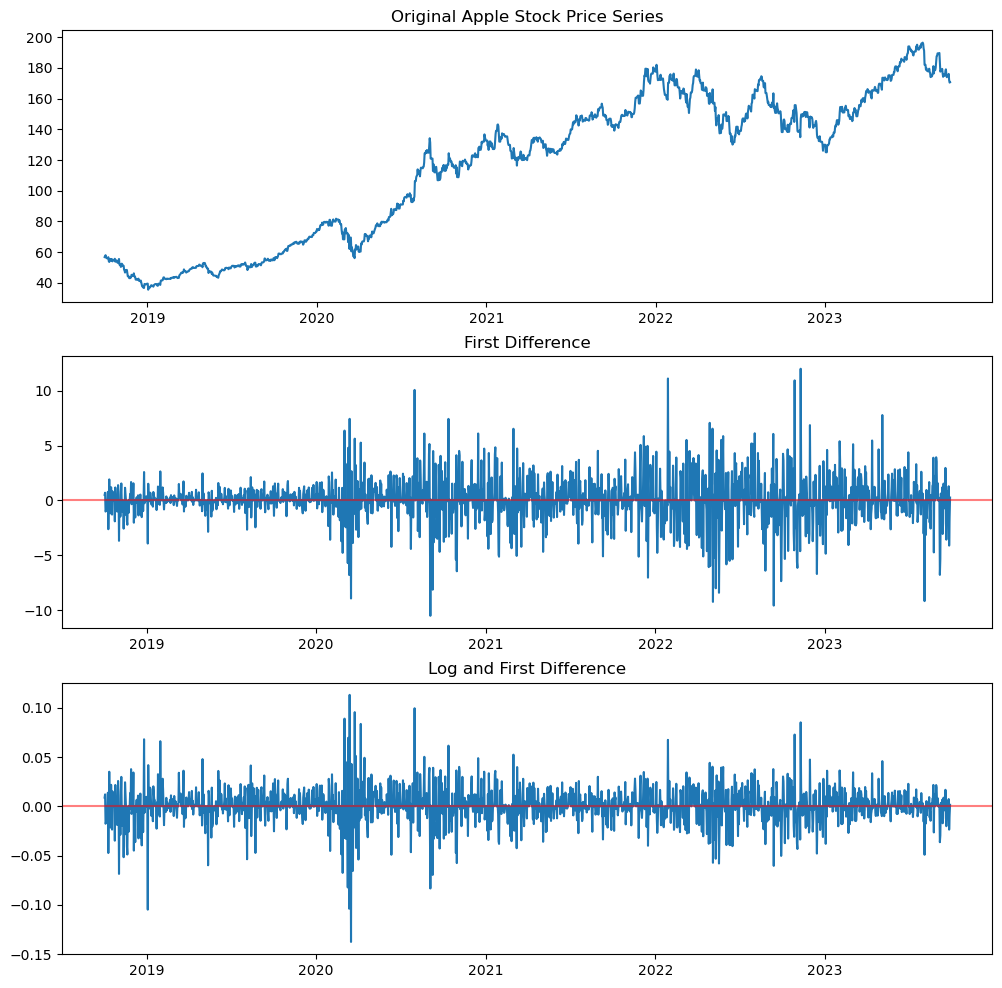

In [16]:
# Check if the series is stationary and transform the series if they are not
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(df['Apple'])
ax[0].set_title('Original Apple Stock Price Series')

ax[1].plot(df['Apple_diff'])
ax[1].set_title('First Difference')
ax[1].axhline(y=df['Apple_diff'].mean(), color='r', alpha=0.5)

ax[2].plot(df['log_Apple_diff'])
ax[2].set_title('Log and First Difference')
ax[2].axhline(y=df['log_Apple_diff'].mean(), color='r', alpha=0.5)

plt.show()

### DBS 

In [17]:
## DBS

# First Differencing
df['DBS_diff'] = df['DBS'].diff()

# Log + First Differencing
df['log_DBS_diff'] = np.log(df['DBS']).diff()

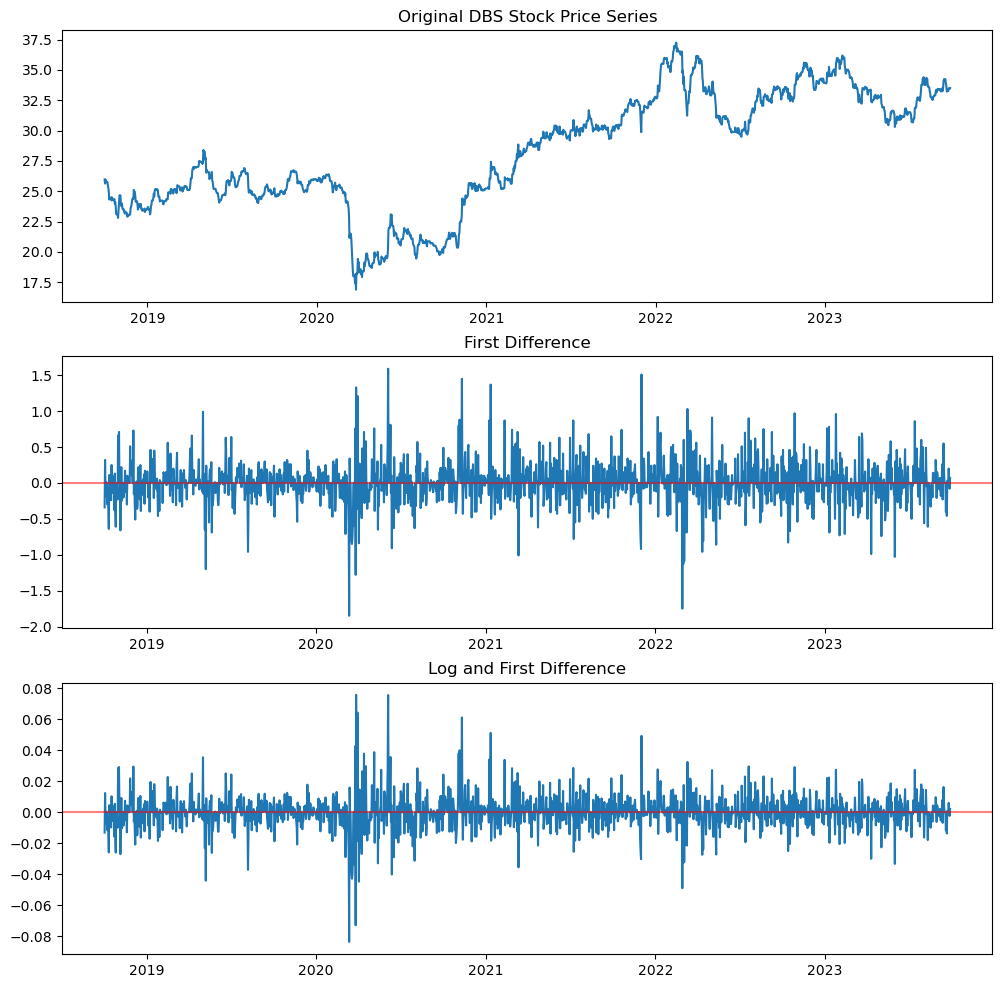

In [18]:
# Check if the series is stationary and transform the series if they are not
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(df['DBS'])
ax[0].set_title('Original DBS Stock Price Series')

ax[1].plot(df['DBS_diff'])
ax[1].set_title('First Difference')
ax[1].axhline(y=df['DBS_diff'].mean(), color='r', alpha=0.5)

ax[2].plot(df['log_DBS_diff'])
ax[2].set_title('Log and First Difference')
ax[2].axhline(y=df['log_DBS_diff'].mean(), color='r', alpha=0.5)

plt.show()

## ADF Test (Again)

After performing first differencing and log + first differencing, I will perform the ADF test again to check for stationarity for df.

In [19]:
df.columns

Index(['Apple', 'Amazon', 'DBS', 'Amazon_diff', 'log_Amazon_diff',
       'Apple_diff', 'log_Apple_diff', 'DBS_diff', 'log_DBS_diff'],
      dtype='object')

In [20]:
company = ['Amazon_diff', 'log_Amazon_diff', 'Apple_diff', 'log_Apple_diff', 'DBS_diff', 'log_DBS_diff']

for company in company:
    # Dropping NaN rows in each column
    dropped_df = df[company].dropna()
    
    # ADF test for stationarity
    adf_result = adfuller(dropped_df)
    print(f'ADF Statistic ({company}): {adf_result[0]}')
    print(f'p-value ({company}): {adf_result[1]}\n')

ADF Statistic (Amazon_diff): -45.203435811872104
p-value (Amazon_diff): 0.0

ADF Statistic (log_Amazon_diff): -45.544593824154525
p-value (log_Amazon_diff): 0.0

ADF Statistic (Apple_diff): -9.092026400579371
p-value (Apple_diff): 3.8015751062016646e-15

ADF Statistic (log_Apple_diff): -8.600725224677648
p-value (log_Apple_diff): 6.880735259649377e-14

ADF Statistic (DBS_diff): -12.91986176636881
p-value (DBS_diff): 3.8951658306102856e-24

ADF Statistic (log_DBS_diff): -13.15584438676391
p-value (log_DBS_diff): 1.337841395234658e-24



* H0 : The series is non-stationary
* H1 : The series is stationary

As p-value is smaller than 0.05, I can reject the null hypothesis of non-stationarity, in favour of stationarity.

I can then conclude that the series are stationary.

## Ljung-Box

In [21]:
# Import module for Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox

In [22]:
logged_values = ['log_Amazon_diff', 'Apple_diff','log_DBS_diff']

for value in logged_values:
    # Drop na values
    dropna_df = df[value].dropna()
    
    # Perform Ljung-Box test for checking autocorrelation in the log differenced time series
    lb_result = acorr_ljungbox(dropna_df, lags=[20], return_df=True)

    # Display the Ljung-Box test results for the log differenced time series
    lbtest_pvalue = lb_result['lb_pvalue']
    print(f"p-value of Ljung-Box Test ({value}): {lbtest_pvalue}\n")

p-value of Ljung-Box Test (log_Amazon_diff): 20    0.002444
Name: lb_pvalue, dtype: float64

p-value of Ljung-Box Test (Apple_diff): 20    0.000016
Name: lb_pvalue, dtype: float64

p-value of Ljung-Box Test (log_DBS_diff): 20    0.000004
Name: lb_pvalue, dtype: float64



Since the p-value is low 

=> I reject the H0 of zero autocorrelations 

=> I can conclude that the series is non-white noise.

## Autocorrelation

### ACF Plot

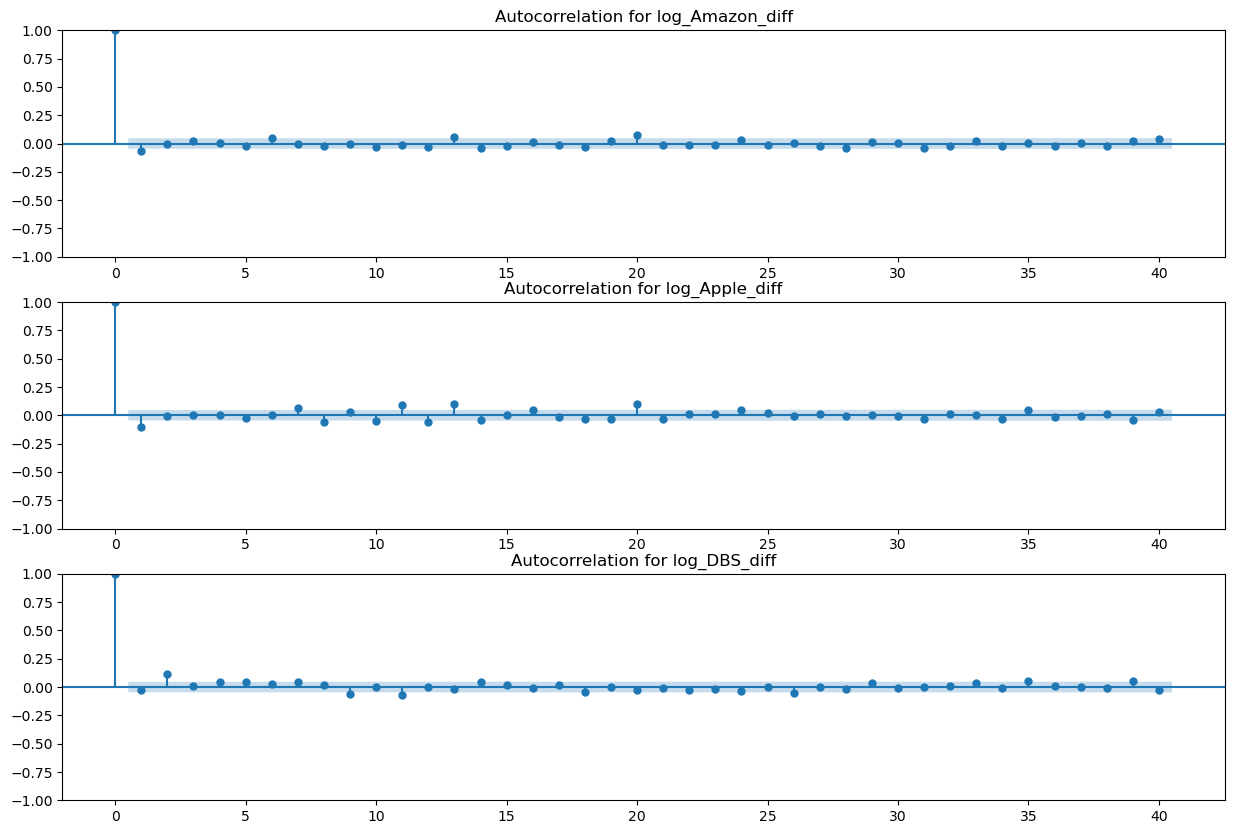

In [23]:
diff_values = ['log_Amazon_diff', 'log_Apple_diff', 'log_DBS_diff']

fig, (axs) = plt.subplots(3,1,figsize=(15,10))

for i, value in enumerate(diff_values):
    log_value = df[value].dropna()
    plot_acf(log_value, lags=40, ax=axs[i])
    axs[i].set_title(f'Autocorrelation for {value}')
plt.show()

### PACF Plot

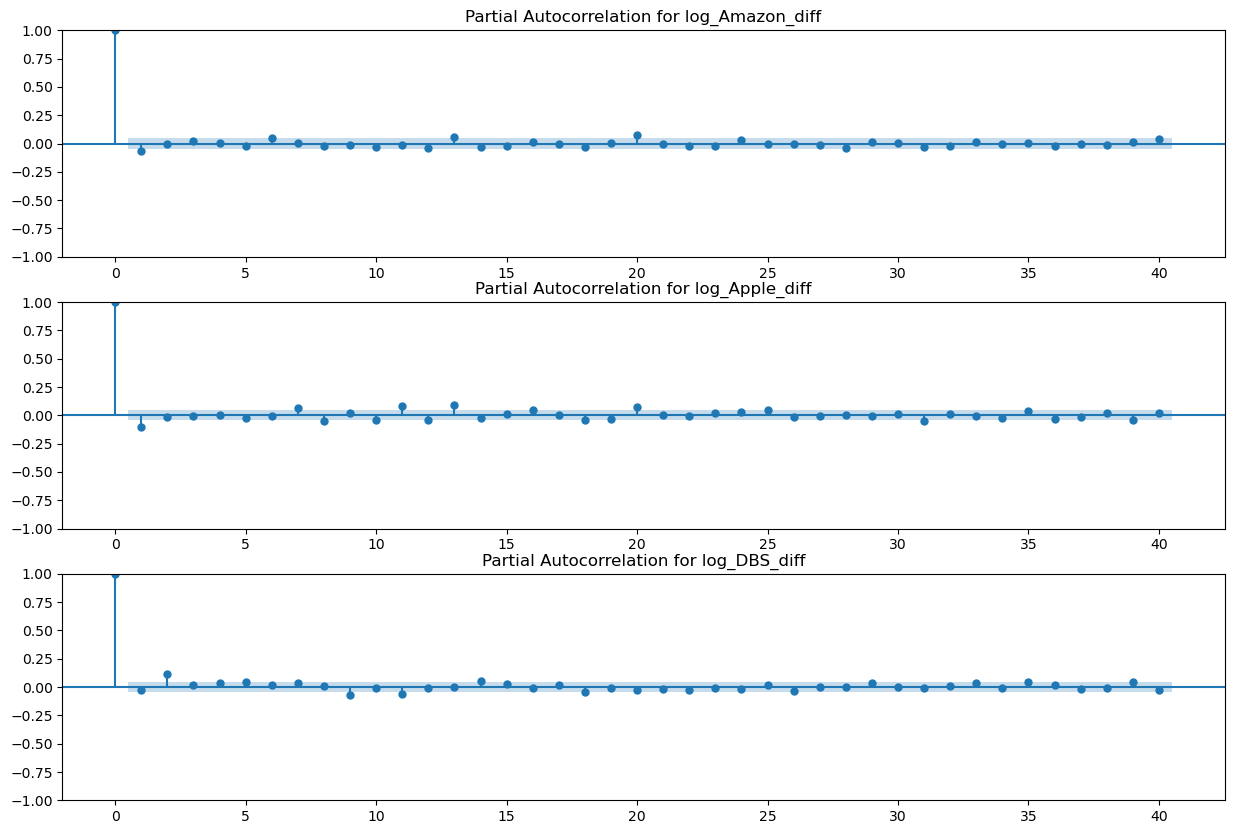

In [24]:
diff_values = ['log_Amazon_diff', 'log_Apple_diff', 'log_DBS_diff']

fig, (axs) = plt.subplots(3,1,figsize=(15,10))

for i, value in enumerate(diff_values):
    log_value = df[value].dropna()
    plot_pacf(log_value, lags=40, ax=axs[i])
    axs[i].set_title(f'Partial Autocorrelation for {value}')
plt.show()

# 2. Modelling timeseries

## Splitting the dataset (Train-Test Split) 

In [25]:
# Splitting train and test datasets
train = df.iloc[:(len(df)-60)]

# Test set has 60 days to mimic the forecast of 60 days
test = df.iloc[(len(df)-60):]

## Modelling

In [26]:
# Import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

I'm only using SARIMAX due to its exogenous variables, which use external data in my forecast.

All the other models, e.g. ARIMA, SARIMA, Exponential Smoothing can only predict a straight line as there is no other features to help train the model.

### Amazon

#### Check for seasonal trend 

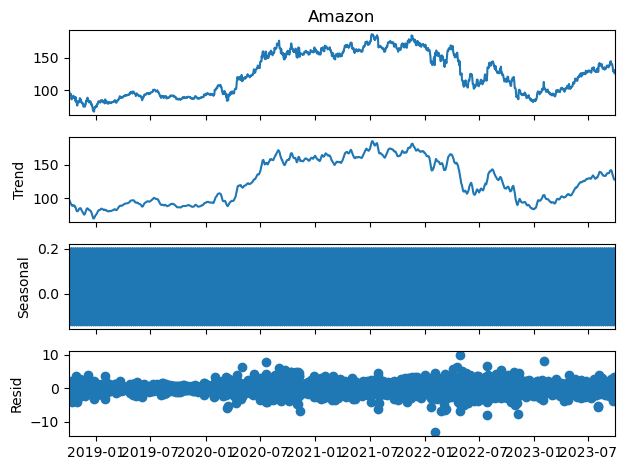

In [27]:
# Plot a seasonal plot to visualize if there is any seasonal trend
seasonal_amazon = seasonal_decompose(df['Amazon'], model="additive")

seasonal_amazon.plot();

<Axes: >

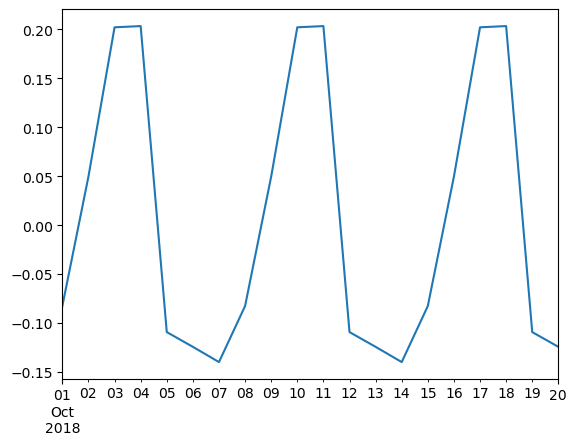

In [28]:
# Finding out the seasonal trend
seasonal_amazon.seasonal.iloc[0:20].plot()

I can identify a seasonal trend of 7 days before it loops again.

#### Since there is a visible seasonal trend, I will be using SARIMAX model on the Amazon data. 

In [29]:
# 'Amazon' data
aic_amazon = []

# Ranges for parameters
p_values = range(0, 3)  # Autoregressive order
d_values = range(1, 2)  # Differencing order
q_values = range(0, 3)  # Moving average order

P_values = range(0, 3)  # Seasonal Autoregressive order
D_values = range(0, 1)  # Seasonal Differencing order
Q_values = range(0, 3)  # Seasonal Moving average order
S_values = [7] 

# Generate all possible combinations of parameters
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values))

for params in param_combinations:
    p, d, q, P, D, Q, S = params
    
    # Fit SARIMAX model
    model = sm.tsa.SARIMAX(endog=train['Amazon'],
                            exog=train[['Apple', 'DBS']],
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, 7),
                            initialization='approximate_diffuse',  
                            enforce_invertibility=False) 
    results = model.fit()

    print(f'Parameters: {params}, AIC: {results.aic}')
    
    aic_amazon.append(results.aic)
    
print(f'Lowest AIC score (Amazon): {min(aic_amazon)}')

Parameters: (0, 1, 0, 0, 0, 0, 7), AIC: 7115.4227596487435
Parameters: (0, 1, 0, 0, 0, 1, 7), AIC: 7193.156390029615
Parameters: (0, 1, 0, 0, 0, 2, 7), AIC: 7274.554866315045
Parameters: (0, 1, 0, 1, 0, 0, 7), AIC: 7188.205146342378
Parameters: (0, 1, 0, 1, 0, 1, 7), AIC: 7191.499788622386
Parameters: (0, 1, 0, 1, 0, 2, 7), AIC: 7276.511465033995
Parameters: (0, 1, 0, 2, 0, 0, 7), AIC: 7265.748552536971
Parameters: (0, 1, 0, 2, 0, 1, 7), AIC: 7266.133304252722
Parameters: (0, 1, 0, 2, 0, 2, 7), AIC: 7278.264283095077
Parameters: (0, 1, 1, 0, 0, 0, 7), AIC: 7127.0729331067305
Parameters: (0, 1, 1, 0, 0, 1, 7), AIC: 7206.165049569445
Parameters: (0, 1, 1, 0, 0, 2, 7), AIC: 7286.30646798625
Parameters: (0, 1, 1, 1, 0, 0, 7), AIC: 7188.5853529860715
Parameters: (0, 1, 1, 1, 0, 1, 7), AIC: 7204.177484781485
Parameters: (0, 1, 1, 1, 0, 2, 7), AIC: 7288.1491873197
Parameters: (0, 1, 1, 2, 0, 0, 7), AIC: 7266.0737403829335
Parameters: (0, 1, 1, 2, 0, 1, 7), AIC: 7266.46400896096
Parameters: (0

Best model parameters:

Parameters: (0, 1, 0, 0, 0, 0, 7), AIC: 7115.4227596487435

In [30]:
# Fitting the best model
best_model_amazon = sm.tsa.SARIMAX(endog=train['Amazon'],
                            exog=train[['Apple', 'DBS']],
                            order=(0, 1, 0),
                            seasonal_order=(0, 0, 0, 7),
                            initialization='approximate_diffuse',  
                            enforce_invertibility=False).fit()


print(best_model_amazon.summary())

                               SARIMAX Results                                
Dep. Variable:                 Amazon   No. Observations:                 1764
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3554.711
Date:                Fri, 09 Feb 2024   AIC                           7115.423
Time:                        19:49:40   BIC                           7131.849
Sample:                    10-01-2018   HQIC                          7121.492
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.7770      0.013     61.604      0.000       0.752       0.802
DBS            0.0599      0.115      0.522      0.602      -0.165       0.285
sigma2         3.2720      0.034     96.123      0.0

Ljung-Box test: 
- High p-value (> 0.05) 
=> fails to reject H0 of no autocorrelations 
=> the residuals are white-noise


Heteroskedasticity test:
- High p-value (> 0.05)
=> fail to reject H0 of homoscedasticity 
=> i.e. residuals are homoscedastic

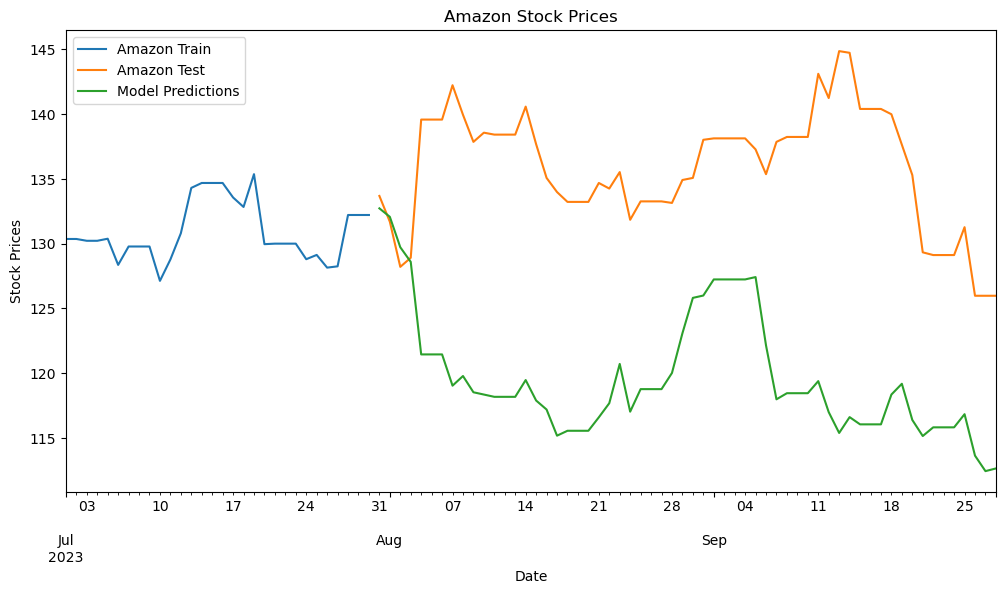

In [31]:
# Model prediction
predictions_amazon = best_model_amazon.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[['Apple', 'DBS']]).rename('Best Amazon Prediction - SARIMAX(0,1,0)(0,0,0,7)')

# Initialize a figure
plt.figure(figsize=(12,6))

# Plotting the train set
train['Amazon'].iloc[-30:].plot(label='Amazon Train')

# Plotting the test set
test['Amazon'].plot(label='Amazon Test')

# Plotting the model's prediction 
predictions_amazon.plot(label='Model Predictions')

plt.title('Amazon Stock Prices')
plt.ylabel('Stock Prices')
plt.xlabel('Date')
plt.legend()
plt.show()

### Apple

#### Check for seasonal trend 

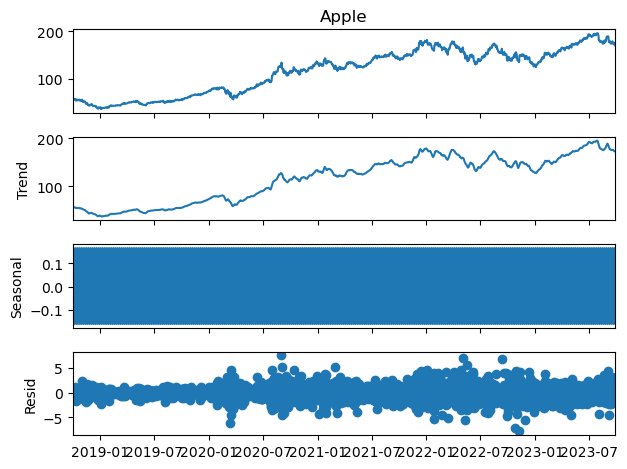

In [32]:
# Plot a seasonal plot to visualize if there is any seasonal trend
seasonal_apple = seasonal_decompose(df['Apple'], model="additive")

seasonal_apple.plot();

<Axes: >

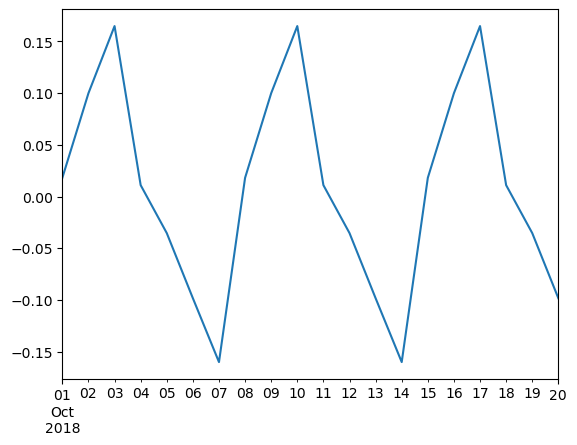

In [33]:
# Finding out the seasonal trend
seasonal_apple.seasonal.iloc[0:20].plot()

Similarly, I can identify a seasonal trend of 7 days before it loops again.

#### Since there is a visible seasonal trend, I will be using SARIMAX model on the Apple data.

In [34]:
# 'Apple' data
aic_apple = []

# Ranges for parameters
p_values = range(0, 3)  # Autoregressive order
d_values = range(1, 2)  # Differencing order
q_values = range(0, 3)  # Moving average order

P_values = range(0, 3)  # Seasonal Autoregressive order
D_values = range(0, 1)  # Seasonal Differencing order
Q_values = range(0, 3)  # Seasonal Moving average order
S_values = [7] 

# Generate all possible combinations of parameters
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values))

for params in param_combinations:
    p, d, q, P, D, Q, S = params
    
    # Fit SARIMAX model
    model = sm.tsa.SARIMAX(endog=train['Apple'],
                            exog=train[['Amazon', 'DBS']],
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, 7),
                            initialization='approximate_diffuse',  
                            enforce_invertibility=False) 
    results = model.fit()

    print(f'Parameters: {params}, AIC: {results.aic}')
    
    aic_apple.append(results.aic)
    
print(f'Lowest AIC score (Apple): {min(aic_apple)}')

Parameters: (0, 1, 0, 0, 0, 0, 7), AIC: 6450.851361998464
Parameters: (0, 1, 0, 0, 0, 1, 7), AIC: 6542.151319639315
Parameters: (0, 1, 0, 0, 0, 2, 7), AIC: 6629.115658199069
Parameters: (0, 1, 0, 1, 0, 0, 7), AIC: 6529.303435227013
Parameters: (0, 1, 0, 1, 0, 1, 7), AIC: 6544.017481389364
Parameters: (0, 1, 0, 1, 0, 2, 7), AIC: 6630.995201686461
Parameters: (0, 1, 0, 2, 0, 0, 7), AIC: 6622.202900499863
Parameters: (0, 1, 0, 2, 0, 1, 7), AIC: 6623.9959714986435
Parameters: (0, 1, 0, 2, 0, 2, 7), AIC: 6631.452846599012
Parameters: (0, 1, 1, 0, 0, 0, 7), AIC: 6462.663178333532
Parameters: (0, 1, 1, 0, 0, 1, 7), AIC: 6554.667782575931
Parameters: (0, 1, 1, 0, 0, 2, 7), AIC: 6642.0923266921145
Parameters: (0, 1, 1, 1, 0, 0, 7), AIC: 6529.030225720833
Parameters: (0, 1, 1, 1, 0, 1, 7), AIC: 6556.6440602941275
Parameters: (0, 1, 1, 1, 0, 2, 7), AIC: 6644.014359840639
Parameters: (0, 1, 1, 2, 0, 0, 7), AIC: 6622.168900964882
Parameters: (0, 1, 1, 2, 0, 1, 7), AIC: 6624.008635688883
Parameters:

Best model parameters:

Parameters: (0, 1, 0, 0, 0, 0, 7), AIC: 6450.851361998464

In [35]:
# Fitting the best model
best_model_apple = sm.tsa.SARIMAX(endog=train['Apple'],
                            exog=train[['Amazon', 'DBS']],
                            order=(0, 1, 0),
                            seasonal_order=(0, 0, 0, 7),
                            initialization='approximate_diffuse',  
                            enforce_invertibility=False).fit()


print(best_model_apple.summary())

                               SARIMAX Results                                
Dep. Variable:                  Apple   No. Observations:                 1764
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3222.426
Date:                Fri, 09 Feb 2024   AIC                           6450.851
Time:                        19:54:42   BIC                           6467.277
Sample:                    10-01-2018   HQIC                          6456.921
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Amazon         0.5330      0.007     79.470      0.000       0.520       0.546
DBS            0.1385      0.087      1.599      0.110      -0.031       0.308
sigma2         2.2445      0.033     67.814      0.0

In [36]:
# Model prediction
predictions_apple = best_model_apple.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[['Amazon', 'DBS']]).rename('Best Apple Prediction - SARIMAX(0,1,0)(0,0,0,7)')

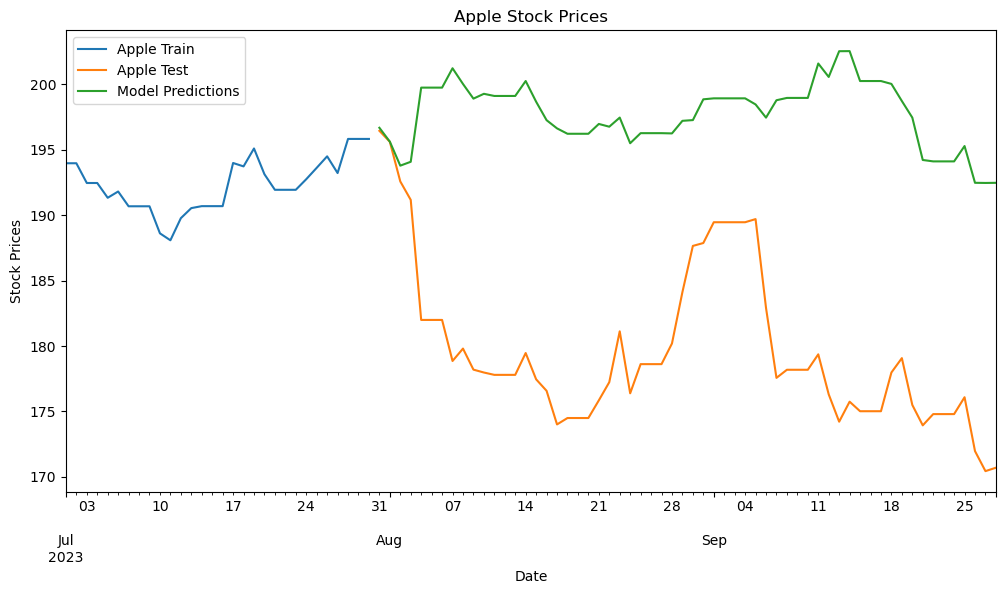

In [37]:
# Initialize a figure
plt.figure(figsize=(12,6))

# Plotting the train set
train['Apple'].iloc[-30:].plot(label='Apple Train')

# Plotting the test set
test['Apple'].plot(label='Apple Test')

# Plotting the model's prediction 
predictions_apple.plot(label='Model Predictions')

plt.title('Apple Stock Prices')
plt.ylabel('Stock Prices')
plt.xlabel('Date')
plt.legend()
plt.show()

### DBS 

#### Check for seasonal trend

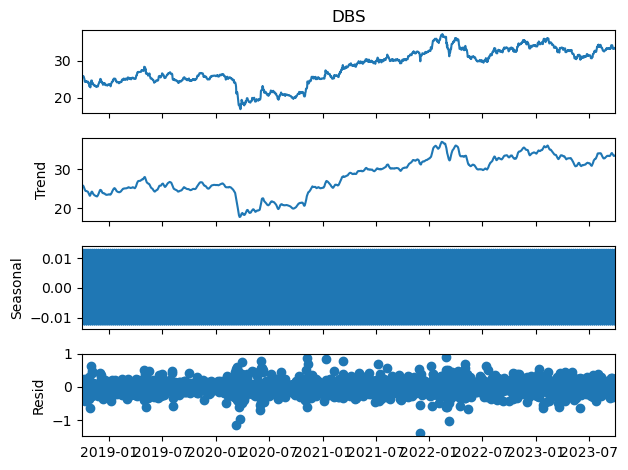

In [38]:
# Plot a seasonal plot to visualize if there is any seasonal trend
seasonal_DBS = seasonal_decompose(df['DBS'], model="additive")

seasonal_DBS.plot();

<Axes: >

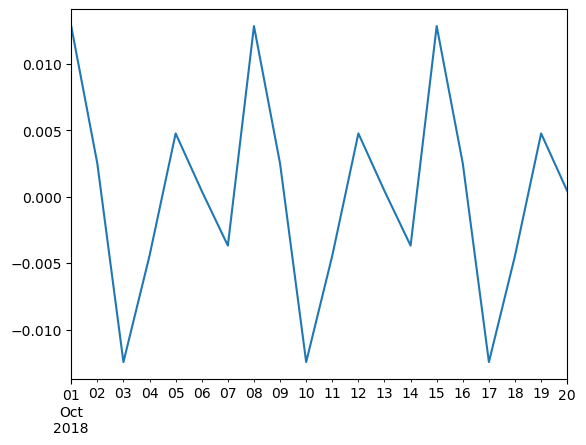

In [39]:
# Finding out the seasonal trend
seasonal_DBS.seasonal.iloc[0:20].plot()

Similar to Amazon and Apply, I can identify a seasonal trend of 7 days before it loops again.

#### Since there is a visible seasonal trend, I will be using SARIMAX model on the Amazon data.

In [40]:
# 'DBS' data
aic_dbs = []

# Ranges for parameters
p_values = range(0, 3)  # Autoregressive order
d_values = range(1, 2)  # Differencing order
q_values = range(0, 3)  # Moving average order

P_values = range(0, 3)  # Seasonal Autoregressive order
D_values = range(0, 1)  # Seasonal Differencing order
Q_values = range(0, 3)  # Seasonal Moving average order
S_values = [7]  # replace with your desired seasonal periods

# Generate all possible combinations of parameters
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values))

for params in param_combinations:
    p, d, q, P, D, Q, S = params
    
    # Fit SARIMAX model
    model = sm.tsa.SARIMAX(endog=train['DBS'],
                            exog=train[['Apple', 'Amazon']],
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, 7),
                            initialization='approximate_diffuse',  
                            enforce_invertibility=False) 
    results = model.fit()

    print(f'Parameters: {params}, AIC: {results.aic}')
    
    aic_dbs.append(results.aic)
    
print(f'Lowest AIC score (DBS): {min(aic_dbs)}')

Parameters: (0, 1, 0, 0, 0, 0, 7), AIC: 505.85212182811347
Parameters: (0, 1, 0, 0, 0, 1, 7), AIC: 616.3077384472899
Parameters: (0, 1, 0, 0, 0, 2, 7), AIC: 724.0444046841922
Parameters: (0, 1, 0, 1, 0, 0, 7), AIC: 602.8601955380807
Parameters: (0, 1, 0, 1, 0, 1, 7), AIC: 616.3583085808027
Parameters: (0, 1, 0, 1, 0, 2, 7), AIC: 726.0108539373559
Parameters: (0, 1, 0, 2, 0, 0, 7), AIC: 709.4269382603261
Parameters: (0, 1, 0, 2, 0, 1, 7), AIC: 711.1511988960776
Parameters: (0, 1, 0, 2, 0, 2, 7), AIC: 723.6606647291694
Parameters: (0, 1, 1, 0, 0, 0, 7), AIC: 521.7212680537801
Parameters: (0, 1, 1, 0, 0, 1, 7), AIC: 632.9268312504948
Parameters: (0, 1, 1, 0, 0, 2, 7), AIC: 740.5377621385071
Parameters: (0, 1, 1, 1, 0, 0, 7), AIC: 603.8848947668823
Parameters: (0, 1, 1, 1, 0, 1, 7), AIC: 633.2332764041889
Parameters: (0, 1, 1, 1, 0, 2, 7), AIC: 742.5349419941585
Parameters: (0, 1, 1, 2, 0, 0, 7), AIC: 710.1461932174548
Parameters: (0, 1, 1, 2, 0, 1, 7), AIC: 711.86768461061
Parameters: (0,

Best model parameters:

Parameters: (0, 1, 0, 0, 0, 0, 7), AIC: 505.85212182811347

In [41]:
# Fitting the best model
best_model_DBS = sm.tsa.SARIMAX(endog=train['DBS'],
                            exog=train[['Apple', 'Amazon']],
                            order=(0, 1, 0),
                            seasonal_order=(0, 0, 0, 7),
                            initialization='approximate_diffuse',  
                            enforce_invertibility=False).fit()


print(best_model_DBS.summary())

                               SARIMAX Results                                
Dep. Variable:                    DBS   No. Observations:                 1764
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -249.926
Date:                Fri, 09 Feb 2024   AIC                            505.852
Time:                        20:00:56   BIC                            522.278
Sample:                    10-01-2018   HQIC                           511.922
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.0048      0.003      1.671      0.095      -0.001       0.010
Amazon         0.0014      0.003      0.539      0.590      -0.004       0.006
sigma2         0.0770      0.001     59.304      0.0

In [42]:
# Model prediction
predictions_DBS = best_model_DBS.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[['Apple', 'Amazon']]).rename('Best DBS Prediction - SARIMAX(0,1,0)(0,0,0,7)')

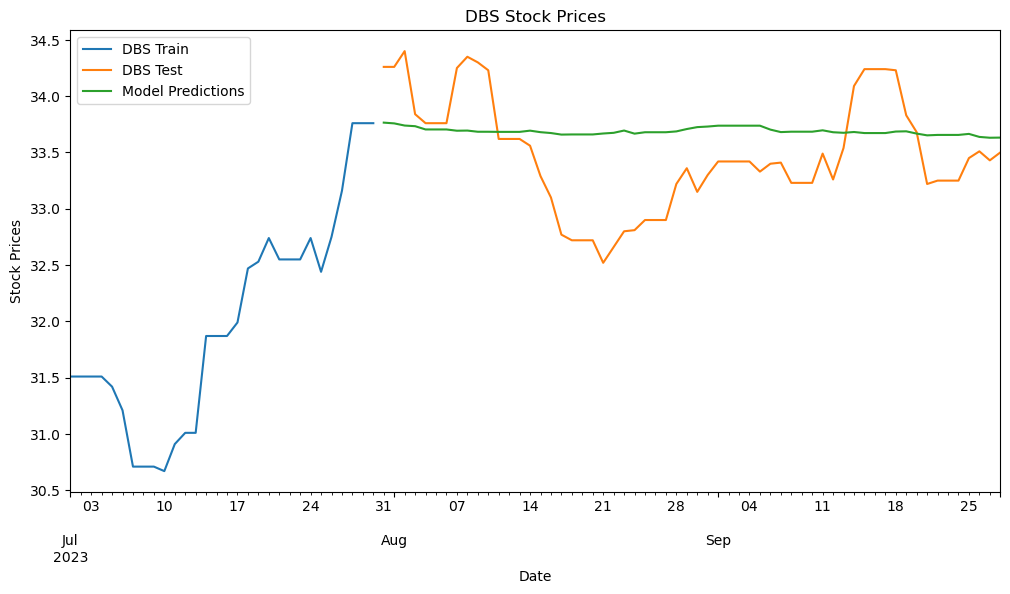

In [43]:
# Initialize a figure
plt.figure(figsize=(12,6))

# Plotting the train set
train['DBS'].iloc[-30:].plot(label='DBS Train')

# Plotting the test set
test['DBS'].plot(label='DBS Test')

# Plotting the model's prediction 
predictions_DBS.plot(label='Model Predictions')

plt.title('DBS Stock Prices')
plt.ylabel('Stock Prices')
plt.xlabel('Date')
plt.legend()
plt.show()

## Why other models are not used

I have tried out some models that I found to use in the modelling of the timeseries. However, they only predict and forecast straight lines.

Other models are lacking the exogenous variable parameter. Without this exogenous variable, majority of the predictions made by other models are simply a straight line, which is no good when it comes to forecasting.

# 3. Evaluate & Forecast

## Evaluate model

Before forecasting 60 days for each of the 3 stock prices, I will be calculating the MSE, RMSE and MAPE.

In [44]:
# Import modules for MAPE, MSE, r2
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [45]:
# Calculations
amazon_MAPE = round(mean_absolute_percentage_error(test['Amazon'], predictions_amazon), 2)
amazon_MSE = round(mean_squared_error(test['Amazon'], predictions_amazon), 2)
amazon_R2 = round(r2_score(test['Amazon'], predictions_amazon), 2)

print(f'Mean Absolute Percentage Error (Amazon): {amazon_MAPE}')
print(f'Mean Squared Error (Amazon) : {amazon_MSE}')
print(f'R-squared (Amazon) : {amazon_R2}')

Mean Absolute Percentage Error (Amazon): 0.12
Mean Squared Error (Amazon) : 301.67
R-squared (Amazon) : -13.82


In [46]:
# Calculations
apple_MAPE = round(mean_absolute_percentage_error(test['Apple'], predictions_apple), 2)
apple_MSE = round(mean_squared_error(test['Apple'], predictions_apple), 2)
apple_R2 = round(r2_score(test['Apple'], predictions_apple), 2)

print(f'Mean Absolute Percentage Error (Apple): {apple_MAPE}')
print(f'Mean Squared Error (Apple) : {apple_MSE}')
print(f'R-squared (Apple) : {apple_R2}')

Mean Absolute Percentage Error (Apple): 0.1
Mean Squared Error (Apple) : 365.72
R-squared (Apple) : -9.1


In [47]:
# Calculations
DBS_MAPE = round(mean_absolute_percentage_error(test['DBS'], predictions_DBS), 2)
DBS_MSE = round(mean_squared_error(test['DBS'], predictions_DBS), 2)
DBS_R2 = round(r2_score(test['DBS'], predictions_DBS), 2)

print(f'Mean Absolute Percentage Error (DBS): {DBS_MAPE}')
print(f'Mean Squared Error (DBS) : {DBS_MSE}')
print(f'R-squared (DBS) : {DBS_R2}')

Mean Absolute Percentage Error (DBS): 0.01
Mean Squared Error (DBS) : 0.28
R-squared (DBS) : -0.15


Even though the model is the same throughout the predictions of the 3 stock prices, the accuracy and measurements calculated are different. 

The model performed best when predicting DBS. However, if we were to look at the shape of the predictions for DBS, the model predicted a close-to-straight line, which may not be a good thing when it comes to forecasting for the stock prices.

## Forecasting

### Amazon 

In [48]:
# Train the best model with the entire data
f_model_amazon = sm.tsa.SARIMAX(endog=df['Amazon'],
                            exog=df[['Apple', 'DBS']],
                            order=(0, 1, 0),
                            seasonal_order=(0, 0, 0, 7),
                            initialization='approximate_diffuse',  
                            enforce_invertibility=False).fit()

In [49]:
# Performing forecasting on 60 days
f_amazon = f_model_amazon.get_forecast(steps=60, exog=df[['Apple', 'DBS']].iloc[-60:])

f_amazon_values = f_amazon.predicted_mean

f_amazon_conf_int = f_amazon.conf_int()

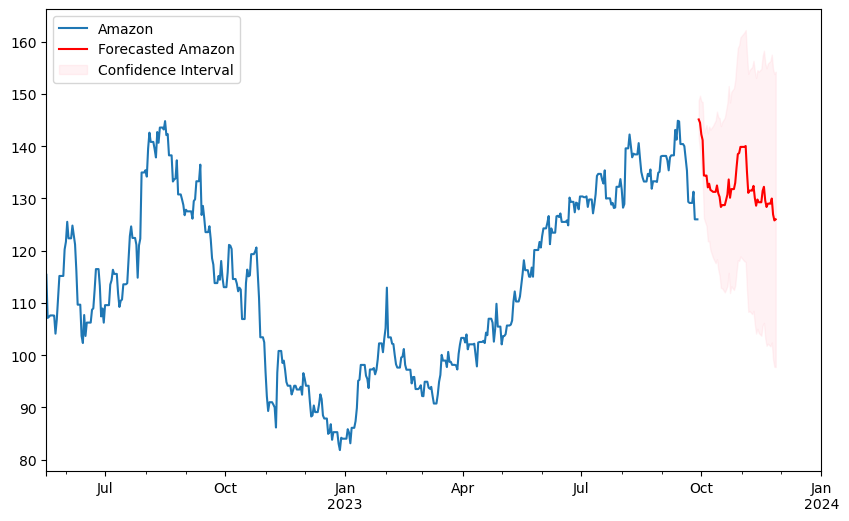

In [50]:
# Plot with forecast
plt.figure(figsize=(10, 6))

# Plotting the whole 'Amazon' plot
df['Amazon'].iloc[-500:].plot(label='Amazon')

# Plotting the forecasted values
f_amazon_values.plot(label='Forecasted Amazon',
                    color='r')

plt.fill_between(
    f_amazon_values.index,
    f_amazon_conf_int.iloc[:, 0],
    f_amazon_conf_int.iloc[:, 1],
    color='Pink',
    alpha=0.2,
    label='Confidence Interval'
)

plt.xlim(df.index[-500].strftime('%Y-%m-%d'), '2024-01-01')

plt.legend(loc='upper left')
plt.show()

In [51]:
# Display the forecasted values
f_amazon_values

2023-09-29    145.103606
2023-09-30    144.482625
2023-10-01    142.257409
2023-10-02    141.156009
2023-10-03    134.361119
2023-10-04    134.361119
2023-10-05    134.361119
2023-10-06    132.091477
2023-10-07    132.804319
2023-10-08    131.608829
2023-10-09    131.438811
2023-10-10    131.241435
2023-10-11    131.241435
2023-10-12    131.241435
2023-10-13    132.469695
2023-10-14    130.955301
2023-10-15    130.284725
2023-10-16    128.350020
2023-10-17    128.706993
2023-10-18    128.706993
2023-10-19    128.706993
2023-10-20    129.683913
2023-10-21    130.726251
2023-10-22    133.616753
2023-10-23    130.113693
2023-10-24    131.771741
2023-10-25    131.771741
2023-10-26    131.771741
2023-10-27    132.973514
2023-10-28    135.893583
2023-10-29    138.481054
2023-10-30    138.659505
2023-10-31    139.847596
2023-11-01    139.847596
2023-11-02    139.847596
2023-11-03    139.847596
2023-11-04    140.015526
2023-11-05    135.003294
2023-11-06    131.049270
2023-11-07    131.488637


### Apple 

In [52]:
# Train the best model with the entire data
f_model_apple = sm.tsa.SARIMAX(endog=df['Apple'],
                            exog=df[['Amazon', 'DBS']],
                            order=(0, 1, 0),
                            seasonal_order=(0, 0, 0, 7),
                            initialization='approximate_diffuse',  
                            enforce_invertibility=False).fit()

In [53]:
# Performing forecasting on 60 days
f_apple = f_model_apple.get_forecast(steps=60, exog=df[['Amazon', 'DBS']].iloc[-60:])

f_apple_values = f_apple.predicted_mean

f_apple_conf_int = f_apple.conf_int()

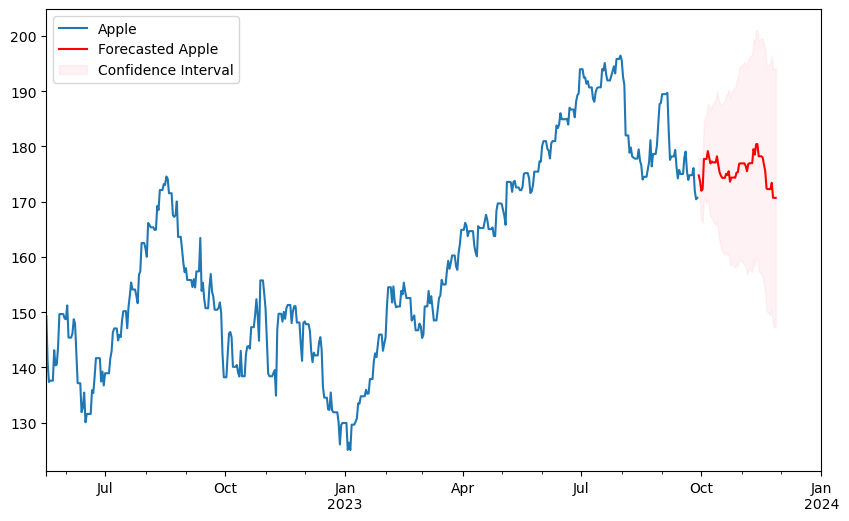

In [54]:
# Plot with forecast
plt.figure(figsize=(10, 6))

# Plotting the whole 'Apple' plot
df['Apple'].iloc[-500:].plot(label='Apple')

# Plotting the forecasted values
f_apple_values.plot(label='Forecasted Apple', 
                          color='r')

plt.fill_between(
    f_apple_values.index,
    f_apple_conf_int.iloc[:, 0],
    f_apple_conf_int.iloc[:, 1],
    color='Pink',
    alpha=0.2,
    label='Confidence Interval'
)

plt.xlim(df.index[-500].strftime('%Y-%m-%d'), '2024-01-01')

plt.legend(loc='upper left')
plt.show()

In [55]:
# Display the forecasted values
f_apple_values

2023-09-29    174.759315
2023-09-30    173.735211
2023-10-01    171.963963
2023-10-02    172.245589
2023-10-03    177.720291
2023-10-04    177.720291
2023-10-05    177.720291
2023-10-06    179.152836
2023-10-07    177.993523
2023-10-08    176.910935
2023-10-09    177.266490
2023-10-10    177.103669
2023-10-11    177.103669
2023-10-12    177.103669
2023-10-13    178.206844
2023-10-14    176.676517
2023-10-15    175.311818
2023-10-16    174.704545
2023-10-17    174.306411
2023-10-18    174.306411
2023-10-19    174.306411
2023-10-20    175.029688
2023-10-21    174.828055
2023-10-22    175.501286
2023-10-23    173.608857
2023-10-24    174.352261
2023-10-25    174.352261
2023-10-26    174.352261
2023-10-27    174.335428
2023-10-28    175.265975
2023-10-29    175.318838
2023-10-30    176.852893
2023-10-31    176.926347
2023-11-01    176.926347
2023-11-02    176.926347
2023-11-03    176.926347
2023-11-04    176.476285
2023-11-05    175.503171
2023-11-06    176.786000
2023-11-07    176.956285


### DBS

In [56]:
# Train the best model with the entire data
f_model_dbs = sm.tsa.SARIMAX(endog=df['DBS'],
                            exog=df[['Amazon', 'Apple']],
                            order=(0, 1, 0),
                            seasonal_order=(0, 0, 0, 7),
                            initialization='approximate_diffuse',  
                            enforce_invertibility=False).fit()

In [57]:
# Performing forecasting on 60 days
f_dbs = f_model_dbs.get_forecast(steps=60, exog=df[['Amazon', 'Apple']].iloc[-60:])

f_dbs_values = f_dbs.predicted_mean

f_dbs_conf_int = f_dbs.conf_int()

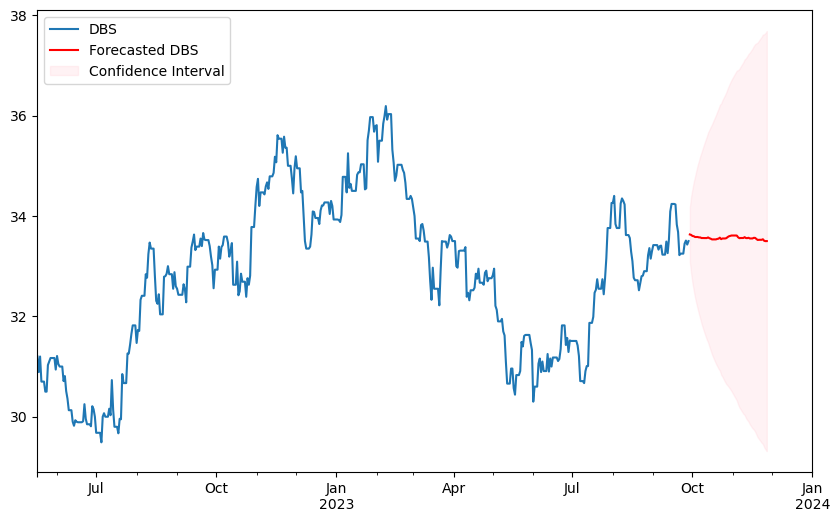

In [58]:
# Plot with forecast
plt.figure(figsize=(10, 6))

# Plotting the whole 'DBS' plot
df['DBS'].iloc[-500:].plot(label='DBS')

# Plotting the forecasted values
f_dbs_values.plot(label='Forecasted DBS',
                 color='r')

plt.fill_between(
    f_dbs_values.index,
    f_dbs_conf_int.iloc[:, 0],
    f_dbs_conf_int.iloc[:, 1],
    color='Pink',
    alpha=0.2,
    label='Confidence Interval'
)

plt.xlim(df.index[-500].strftime('%Y-%m-%d'), '2024-01-01')

plt.legend(loc='upper left')
plt.show()

In [59]:
# Display the forecasted values
f_dbs_values

2023-09-29    33.631500
2023-09-30    33.623193
2023-10-01    33.601777
2023-10-02    33.597171
2023-10-03    33.581283
2023-10-04    33.581283
2023-10-05    33.581283
2023-10-06    33.573546
2023-10-07    33.572471
2023-10-08    33.560535
2023-10-09    33.561204
2023-10-10    33.560063
2023-10-11    33.560063
2023-10-12    33.560063
2023-10-13    33.572426
2023-10-14    33.556852
2023-10-15    33.546960
2023-10-16    33.533097
2023-10-17    33.533504
2023-10-18    33.533504
2023-10-19    33.533504
2023-10-20    33.542836
2023-10-21    33.547978
2023-10-22    33.568084
2023-10-23    33.538657
2023-10-24    33.551782
2023-10-25    33.551782
2023-10-26    33.551782
2023-10-27    33.558479
2023-10-28    33.579916
2023-10-29    33.595868
2023-10-30    33.603633
2023-10-31    33.610905
2023-11-01    33.610905
2023-11-02    33.610905
2023-11-03    33.610905
2023-11-04    33.610000
2023-11-05    33.575615
2023-11-06    33.557754
2023-11-07    33.561368
2023-11-08    33.561368
2023-11-09    33